<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.5
## Feature Selection

### Data

**Predict the onset of diabetes based on diagnostic measures.**

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

[Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database/download)

In [9]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression

#### 1. Load Data

In [10]:
# Read Data
diabetes = pd.read_csv('../../DATA/diabetes.csv')

In [11]:
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


#### 2. Perform EDA

Perform EDA. Check Null Values. Impute if necessary.

In [12]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [13]:
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

C:\Users\User\AppData\Local\Temp\ipykernel_8636\3267200254.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(diabetes.corr(), dtype=np.bool)


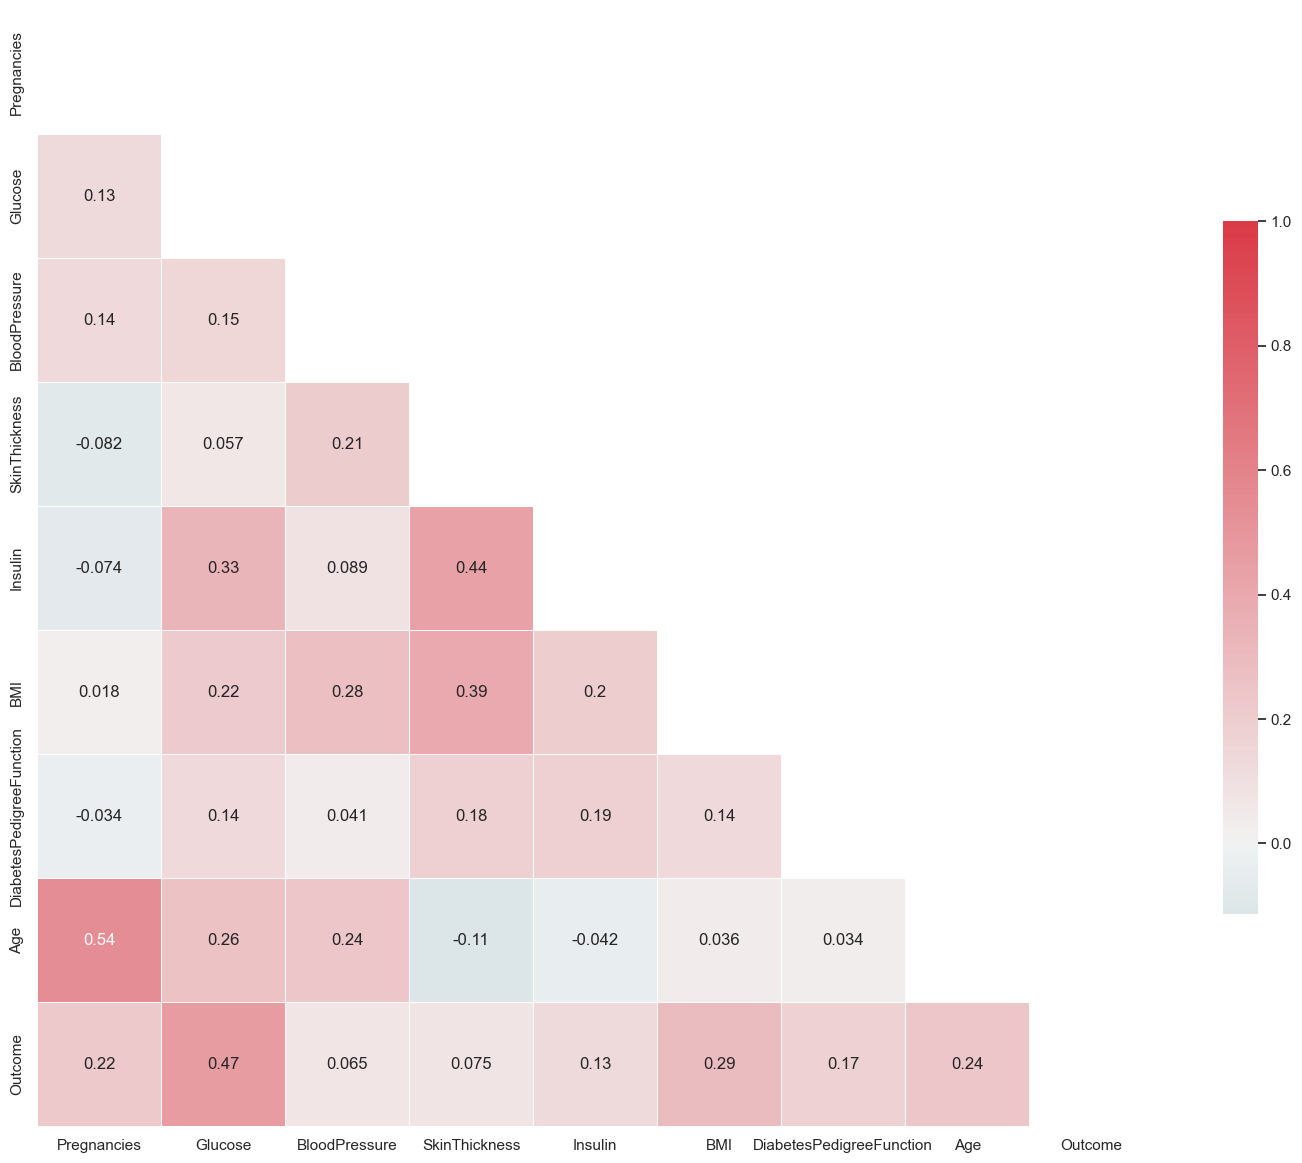

In [14]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(diabetes.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(diabetes.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show();

#### 3. Set Target

- Set `Outcome` as target.
- Set Features 

In [16]:
feature_columns = [c for c in diabetes.columns if c != 'Outcome']

In [17]:
y = diabetes['Outcome']
X = diabetes[feature_columns]

In [18]:
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [19]:
y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

#### 4. Select Feature

The classes in the sklearn.feature_selection module can be used for feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets.

##### 4.1 Univariate Selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. Scikit-learn exposes feature selection routines as objects that implement the transform method:

- SelectKBest removes all but the  highest scoring features
- Use sklearn.feature_selection.chi2 as score function
    > Recall that the chi-square test measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.


More Reads:
[Univariate feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)

- Create an instance of SelectKBest
    - Use sklearn.feature_selection.chi2 as score_func
    - Use k of your choice
- Fit X, y 
- Find top 4 features
- Transform features to a DataFrame

In [ ]:
# Create an instance of SelectKBest

In [ ]:
# Fit 

In [ ]:
# Print Score 
# Find Top 4 Features

In [ ]:
# Transform X to Features

In [ ]:
# Transform features to a dataframe

##### 4.2 Recursive feature elimination

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

More Reads:
[Recursive feature elimination](https://scikit-learn.org/stable/modules/feature_selection.html)

- Use RFE to extract feature
    - use LogisticRegression as estimator
    - Number of n_features_to_select as of your choice
- Fit X, y to RFE
- Find Selected Features

In [ ]:
# ANSWER

In [ ]:
# Print Score 
# Find Features



---



---



> > > > > > > > > © 2022 Institute of Data


---



---



